# 🚢 Titanic classifier

🎯 In this challenge, the goal is to use SVM classifiers to predict whether a passenger survived or not (accuracy score), and compare your performance with your buddy of the day on an unseen test set that you will both share. Be aware that you will only have one trial on the test set!

In [149]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import stats
np.random.seed(8)

🚢 Import the `Titanic dataset`:

In [2]:
import seaborn as sns
data = sns.load_dataset('titanic').drop(columns=['alive'])
data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,True


❓ **Question (Game Plan**) ❓ 

Write down below in plain english the different steps you are going to perform to answer the question.

- Eliminate duplicates
- Handle missing data
- Handle Outliers
- Separate data in training and test sets
- Scale numerical features
- Encode categorical features
- Create model
- Separate training set in training and validation
- Use random search or grid search tools to find best hyper parameters 
- Test in validation set

<details><summary>👨🏻‍🏫 <i>Read our answer suggested answer here</i></summary>
    
    
0. 🧹 Data Cleaning
1. ✂️ Train/Test Split
2. 🔡 Feature Encoding
3. ⚖️ Feature Scaling
4. 🐣 A first model
5. 🤖 Model Tuning: Cross-Validated RandomSearch (Coarse Grain approach first, Fine Grain afterwards)
6. 🕵🏻 True performance analysis on the test set
</details>

## (0) 🧹 Data Cleaning

❓ **Question (Duplicated rows)** ❓

Are there any duplicated rows ? If so, drop them.

In [7]:
# original number of rows
len(data)

891

In [6]:
data.duplicated().sum()

107

107 duplicated rows

In [8]:
data = data.drop_duplicates()

In [9]:
# number of rows without duplicates
len(data)

784

❓ **Question (Missing values)** ❓

In which columns do we have missing values ?

Drop the column if there are too many missing values or impute these missing values.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     784 non-null    int64   
 1   pclass       784 non-null    int64   
 2   sex          784 non-null    object  
 3   age          678 non-null    float64 
 4   sibsp        784 non-null    int64   
 5   parch        784 non-null    int64   
 6   fare         784 non-null    float64 
 7   embarked     782 non-null    object  
 8   class        784 non-null    category
 9   who          784 non-null    object  
 10  adult_male   784 non-null    bool    
 11  deck         202 non-null    category
 12  embark_town  782 non-null    object  
 13  alone        784 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(4)
memory usage: 70.9+ KB


In [15]:
data.isnull().sum()/len(data)*100

survived        0.000000
pclass          0.000000
sex             0.000000
age            13.520408
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.255102
class           0.000000
who             0.000000
adult_male      0.000000
deck           74.234694
embark_town     0.255102
alone           0.000000
dtype: float64

In [16]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [19]:
data[data['age'].isnull()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,True
17,1,2,male,NaN,0,0,13.0000,S,Second,man,True,NaN,Southampton,True
19,1,3,female,NaN,0,0,7.2250,C,Third,woman,False,NaN,Cherbourg,True
26,0,3,male,NaN,0,0,7.2250,C,Third,man,True,NaN,Cherbourg,True
28,1,3,female,NaN,0,0,7.8792,Q,Third,woman,False,NaN,Queenstown,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,1,3,male,NaN,0,0,7.7500,Q,Third,man,True,NaN,Queenstown,True
839,1,1,male,NaN,0,0,29.7000,C,First,man,True,C,Cherbourg,True
849,1,1,female,NaN,1,0,89.1042,C,First,woman,False,C,Cherbourg,False
868,0,3,male,NaN,0,0,9.5000,S,Third,man,True,NaN,Southampton,True


In [21]:
# drop deck feature
data = data.drop(columns=['deck'])

In [25]:
# replace null values of age with sklearn simple imputer mean strategy
simple_imputer = SimpleImputer(strategy='mean')
data['age'] = simple_imputer.fit_transform(data[['age']])


In [26]:
data.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       2
class          0
who            0
adult_male     0
embark_town    2
alone          0
dtype: int64

In [57]:
data[data.embark_town.isna()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alone
61,1,1,female,38.0,0,0,80.0,NaN,First,woman,False,NaN,True
829,1,1,female,62.0,0,0,80.0,NaN,First,woman,False,NaN,True


In [59]:
data = data.dropna(subset=['embark_town']) 

## (1) ✂️ Holdout

❓ **Question (Train-Test-Split)** ❓ 

* Holdout 30% of your dataset as the test set for a final evaluation  
    * Use `random_state=0` to compare your final results with your buddy's results)

In [61]:
X = data.drop(columns=['survived'])

In [62]:
y= data['survived']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [64]:
print(len(X_train), len(X_test))

547 235


## (2) 🔡 Encoding (the categorical variables)

✅ **Encoding the target**

👇 Your target is either `survived` or `died`. It was already done for you as shown down below.

In [65]:
data.survived.value_counts()

0    461
1    321
Name: survived, dtype: int64

❓ **Question (Encoding the categorical features)** ❓

In [66]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alone
416,2,female,34.0,1,1,32.5000,S,Second,woman,False,Southampton,False
874,2,female,28.0,1,0,24.0000,C,Second,woman,False,Cherbourg,False
285,3,male,33.0,0,0,8.6625,C,Third,man,True,Cherbourg,True
226,2,male,19.0,0,0,10.5000,S,Second,man,True,Southampton,True
342,2,male,28.0,0,0,13.0000,S,Second,man,True,Southampton,True


In [84]:
categorical_mask = X_train.select_dtypes(exclude=['int64', 'float64']).columns
categorical_mask

Index(['sex', 'embarked', 'class', 'who', 'adult_male', 'embark_town',
       'alone'],
      dtype='object')

In [68]:
ohe = OneHotEncoder(sparse = False, drop="if_binary")
ohe.fit(X_train[categorical_mask])
ohe

OneHotEncoder(drop='if_binary', sparse=False)

In [69]:
X_train_encoded = pd.DataFrame(ohe.transform(X_train[categorical_mask]), columns=ohe.get_feature_names_out())
X_train_encoded.head()

,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,adult_male_True,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_True
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [70]:
X_test_encoded = pd.DataFrame(ohe.transform(X_test[categorical_mask]), columns=ohe.get_feature_names_out())
X_test_encoded.head()

,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,adult_male_True,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_True
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


In [ ]:
##############################################
# Lewagon SOLUTION 1 - Scikit Learn - OneHot Encoder #
##############################################

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop = "if_binary", # Doesn't create an extra column for binary features
                    sparse = False, # Returns full matrixes with zeros where need be instead of sparse matrixes
                    handle_unknown="ignore") # Useful to set everything to zero for unseen categories in the test set

ohe.fit(X_train[categorical_features])


ohe.categories_

## (3) ⚖️ Feature Scaling

❓ **Question (Scaling)** ❓

Scale *both* your training set and your test set using the scaler of your choice

In [87]:
numerical_mask = ['age', 'sibsp', 'parch', 'fare']

In [88]:
X_train[numerical_mask].head()

,age,sibsp,parch,fare
416,34.0,1,1,32.5000
874,28.0,1,0,24.0000
285,33.0,0,0,8.6625
226,19.0,0,0,10.5000
342,28.0,0,0,13.0000


In [89]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alone
416,2,female,34.0,1,1,32.5000,S,Second,woman,False,Southampton,False
874,2,female,28.0,1,0,24.0000,C,Second,woman,False,Cherbourg,False
285,3,male,33.0,0,0,8.6625,C,Third,man,True,Cherbourg,True
226,2,male,19.0,0,0,10.5000,S,Second,man,True,Southampton,True
342,2,male,28.0,0,0,13.0000,S,Second,man,True,Southampton,True


In [90]:
X_train[numerical_mask].describe()

,age,sibsp,parch,fare
count,547.000000,547.000000,547.000000,547.000000
mean,30.078915,0.526508,0.435101,35.246039
std,14.149954,0.943811,0.877524,52.069518
min,0.670000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,8.050000
50%,29.869351,0.000000,0.000000,15.850000
75%,37.500000,1.000000,1.000000,35.250000
max,80.000000,5.000000,6.000000,512.329200


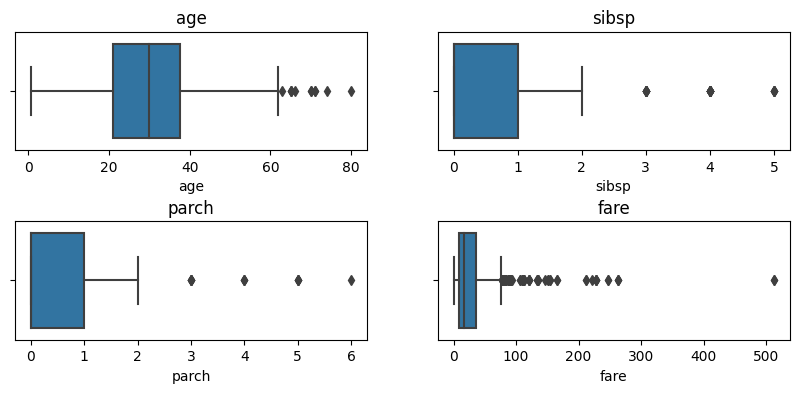

In [106]:
# Start a figure
plt.figure(figsize=(10,4))
# First subplot
plt.subplot(2,2,1)
sns.boxplot(data=X_train, x='age')
plt.title('age')
# Second subplot
plt.subplot(2,2,2) 
sns.boxplot(data=X_train, x='sibsp')
plt.title("sibsp")
# Third subplot
plt.subplot(2,2,3) 
sns.boxplot(data=X_train, x='parch')
plt.title("parch")
# Fourth subplot
plt.subplot(2,2,4) 
sns.boxplot(data=X_train, x='fare')
plt.title("fare")

plt.subplots_adjust(wspace=0.2, 
                    hspace=0.6)



In [108]:
rs = RobustScaler()
rs.fit(X_train[numerical_mask])
rs

RobustScaler()

In [110]:
X_train_scaled = pd.DataFrame(rs.transform(X_train[numerical_mask]), columns= numerical_mask)
X_train_scaled.head()

,age,sibsp,parch,fare
0,0.250342,1.0,1.0,0.612132
1,-0.113294,1.0,0.0,0.299632
2,0.189736,0.0,0.0,-0.264246
3,-0.658749,0.0,0.0,-0.196691
4,-0.113294,0.0,0.0,-0.104779


In [111]:
X_test_scaled = pd.DataFrame(rs.transform(X_test[numerical_mask]), columns= numerical_mask)
X_test_scaled.head()

,age,sibsp,parch,fare
0,-1.204203,0.0,2.0,0.305147
1,2.068524,0.0,0.0,0.373162
2,0.310948,1.0,0.0,1.329044
3,-0.961779,0.0,0.0,-0.293963
4,0.000000,0.0,0.0,-0.313879


In [112]:
X_train_transformed = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_train_transformed.head()

,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,adult_male_True,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_True,age,sibsp,parch,fare
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.250342,1.0,1.0,0.612132
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.113294,1.0,0.0,0.299632
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.189736,0.0,0.0,-0.264246
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.658749,0.0,0.0,-0.196691
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.113294,0.0,0.0,-0.104779


In [113]:
X_test_transformed = pd.concat([X_test_encoded, X_test_scaled], axis=1)
X_test_transformed.head()

,sex_male,embarked_C,embarked_Q,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,adult_male_True,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_True,age,sibsp,parch,fare
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.204203,0.0,2.0,0.305147
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.068524,0.0,0.0,0.373162
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.310948,1.0,0.0,1.329044
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.961779,0.0,0.0,-0.293963
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,-0.313879


## (4) 🐣 Baseline Model

❓ **Question (Starting with a simple model...) ❓

Cross-validate a Linear SVC model as your baseline model, using the accuracy score. 

In [118]:
model = SVC()
base_score = cross_val_score(model, X=X_train_transformed, y=y_train, cv=5)
base_score.mean()

0.8207506255212677

## (5) 🧨 Random Search

❓ **Question (Optimizing a Support Vector Classifier)** ❓

*  Use a **RandomizedSearchCV** to optimize both the parameters `kernel` and `C` of an SVM classifier (SVC)
    - Start with a total of `n_iter=100` combinations, cross-validated `cv=5` times each
    - Use `verbose=1`to check progress
    - Use `n_jobs=-1` to use all your CPU cores
    - (Optional) You can also optimize other parameters of your choice if you want to.

☣️ If the `RandomizedSearchCV` seems stuck after more than 10 seconds, perform one search per SVM kernel. Scikit-Learn sometimes experiences issues with _Searching_ multiple kernels at a time

In [140]:

######################
# Instanciate model  #
######################
model_tuned_linear = SVC()


#################################
# Hyperparameters' search space #
#################################
grid = {'kernel' : ['poly', 'rbf', 'sigmoid'],
        'C': stats.norm(2,0.33),
        'gamma': ['scale', 'auto']
       }


################################
# Instanciate Random Search    #
################################
search = RandomizedSearchCV(model_tuned,
                            grid,
                           scoring='accuracy',
                           cv=5,
                           n_iter=100,
                           verbose=1,
                           n_jobs=-1)
# Fit search 
search.fit(X_train_transformed, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292eac4f0>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   scoring='accuracy', verbose=1)

❓ **Question(Optimized Model and its performance)** ❓

* What are the best parameters ?
* What is the best score?

In [141]:
search.best_params_

{'C': 2.09184361672549, 'gamma': 'auto', 'kernel': 'rbf'}

In [142]:
search.best_score_

0.8225854879065888

## (6) 🕵️‍♀️ Final test score and Confusion Matrix

❓ **Question (Evaluating on the test set)** ❓

* Select the best model you want to test. You will compare your result with your buddy of the day!

* Compute its `accuracy`, `classification_report` and show the `confusion_matrix` on the test set.

☣️ You can only test one model. Once you have seen the test set, any other optimization would result in data leakage 

In [145]:
best = search.best_estimator_

In [147]:
y_pred = best.predict(X_test_transformed)
y_pred

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [148]:
accuracy_score(y_test, y_pred)

0.7829787234042553

In [151]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       126
           1       0.77      0.75      0.76       109

    accuracy                           0.78       235
   macro avg       0.78      0.78      0.78       235
weighted avg       0.78      0.78      0.78       235



❓ **Question (Confusion Matrix)** ❓

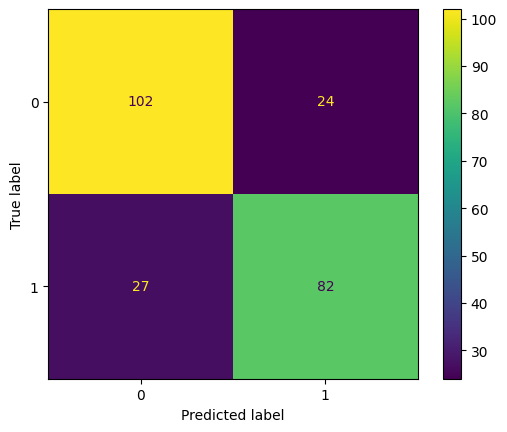

In [152]:
ConfusionMatrixDisplay.from_estimator(best, X_test_transformed, y_test)

🏁 Congratulations! You were able to tackle a classification task from A to Z, cleaning your dataset, encoding and scaling your features, optimizing your model... !

💾 Don't forget to git add/commit/push your notebook...

🚀 ... and move on to the next challenge!